Nama : Ibnu Amuna Malik 

Email : amunamalik12@gmail.com / ibnu17002@mail.unpad.ac.id 

link dataset yang dipakai pada kaggle : https://www.kaggle.com/htagholdings/property-sales

dataset yang dipakai merupakan dataset timeseries penjualan rumah dan unit dengan tipe jumlah kamar yang berbeda dari tahun 2007-2019. dengan dataset berjumlah kurang lebih 25ribu row, namun setelah dirapih dan disisihkan untuk membuat model timeseries yang dibutuhkan, jumlah data yang dipakai sebesar 12201 row. 

In [15]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [25]:
data= pd.read_csv('raw_sales.csv')
data = data.drop(columns='postcode')
data = data[data.propertyType != 'unit'] # menghilangkan propertytype selain rumah agar data yang diolah data rumah saja
data = data[data.bedrooms != 4] # menghilangkan tipe rumah selain kategori bedroom 4, yang diolah hanyalah rumah dengan bedroom 4
data = data[data.bedrooms != 5] 
data

,datesold,price,propertyType,bedrooms
1,2007-02-27 00:00:00,290000,house,3
2,2007-03-07 00:00:00,328000,house,3
4,2007-03-21 00:00:00,310000,house,3
6,2007-04-24 00:00:00,399000,house,3
8,2007-05-24 00:00:00,359000,house,3
...,...,...,...,...
24541,2019-07-25 00:00:00,628000,house,3
24542,2019-07-25 00:00:00,731000,house,3
24545,2019-07-25 00:00:00,1130000,house,3
24546,2019-07-26 00:00:00,470000,house,3


In [26]:
data.isnull().sum() # mengecek apakah ada nilai yang hilang atau tidak 

datesold        0
price           0
propertyType    0
bedrooms        0
dtype: int64

In [28]:
data.apply(np.min) # mencari nilai minimum pada tiap kategori untuk menentukan MAE nya

datesold        2007-02-27 00:00:00
price                         69000
propertyType                  house
bedrooms                          0
dtype: object

In [29]:
data.apply(np.max) # mencari nilai maksimal pada tiap kategori untuk menentukan MAE nya

datesold        2019-07-26 00:00:00
price                       6480000
propertyType                  house
bedrooms                          3
dtype: object

SKALA DATA = 6480000 - 69000 = 6411000
MAE MINIMAL = 6411000 x 10 % = 641100

Valuasi dikatakan sesuai dengan persayaratan apabila MAE sama atau lebih kecil sama dengan 641100 pada train ataupun valuasi 

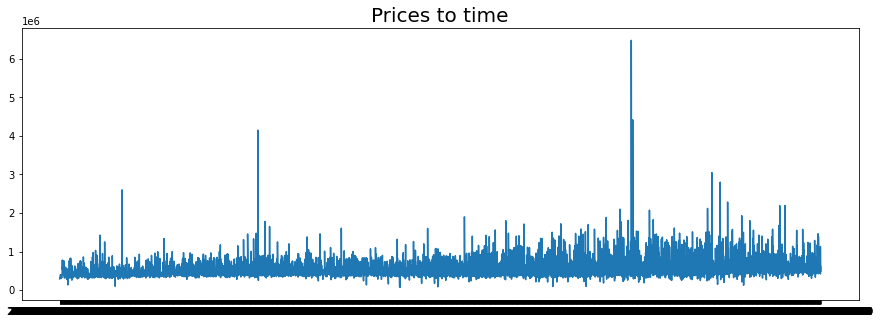

In [30]:
dates = data['datesold'].values
prices  = data['price'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, prices)
plt.title('Prices to time',
          fontsize=20); # membuat plot grafik harga terlebih dahulu 

In [38]:
dates

array(['2007-02-27 00:00:00', '2007-03-07 00:00:00',
       '2007-03-21 00:00:00', ..., '2019-07-25 00:00:00',
       '2019-07-26 00:00:00', '2019-07-26 00:00:00'], dtype=object)

In [39]:
prices

array([ 290000,  328000,  310000, ..., 1130000,  470000,  610000])

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1) # membuat window dataset untuk timeseries

In [40]:
train_data_dates = dates[:int((len(dates)+1)*.80)] 
test_data_dates = dates[int(len(dates)*.80+1):] 
train_data_price = prices[:int((len(prices)+1)*.80)] 
test_data_price = prices[int(len(prices)*.80+1):] # mengatur agar data memiliki 80% train data dan 20% test data

In [41]:
train_data_dates

array(['2007-02-27 00:00:00', '2007-03-07 00:00:00',
       '2007-03-21 00:00:00', ..., '2017-09-20 00:00:00',
       '2017-09-20 00:00:00', '2017-09-20 00:00:00'], dtype=object)

In [47]:
train_data_price = train_data_price.astype(float)
test_data_price = test_data_price.astype(float) # mengubah tipe data train dan test menjadi float agar bisa ditrain, karena hasil latih memiliki nilai desimal 

In [48]:
train_set = windowed_dataset(train_data_price, window_size=100, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(test_data_price, window_size=100, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dense(20, activation="relu"),
  tf.keras.layers.Dense(4),
]) # mengatur sekuens dari model 
   # mengatur LSTM 

In [50]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9) #mengaplikasikan learning rate pada model optimizer 
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=100, validation_data=test_set)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
97/97 [==============================] - 63s 614ms/step - loss: 116929.3594 - mae: 116929.8594 - val_loss: 137567.7969 - val_mae: 137568.2969
Epoch 2/100
97/97 [==============================] - 57s 584ms/step - loss: 116605.6250 - mae: 116606.1719 - val_loss: 138457.6719 - val_mae: 138458.1406
Epoch 3/100
97/97 [==============================] - 57s 590ms/step - loss: 117363.9297 - mae: 117364.4453 - val_loss: 134831.0469 - val_mae: 134831.5156
Epoch 4/100
97/97 [==============================] - 57s 589ms/step - loss: 116975.1875 - mae: 116975.6797 - val_loss: 131042.7734 - val_mae: 131043.2656
Epoch 5/100
97/97 [==============================] - 57s 586ms/step - loss: 118924.4844 - mae: 118924.9297 - val_loss: 142533.3906 - val_mae: 142533.8906
Epoch 6/100
97/97 [==============================] - 58s 598ms/step - loss: 115646.2344 - mae: 115646.7344 - val_loss: 141460.1094 - val_mae: 141460.6094
Epoch 7/100
97/97 [==============================] - 58s 593ms/step - loss: 

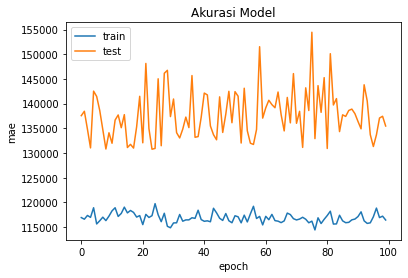

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Akurasi Model')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() #melihat mae dari model untuk train dan test yang telah di execute

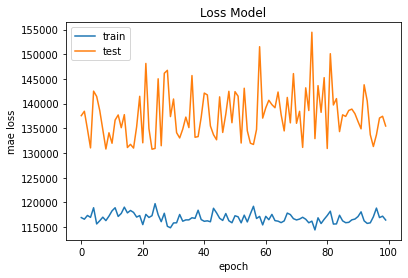

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_mae'])
plt.title('Loss Model')
plt.ylabel('mae loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() # melihat model mae loss untuk ML yang telah di execute 

Pada percobaan diatas dapat disimpulkan berhasil karena MAE yang dihasilkan jauh dibawah dengan 10% skala data yaitu 641100, MAE yang didapat berada di kisaran 115000-120000 untuk data train dan 130000-155000 untuk data validation 